In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/bureau.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv


In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit, learning_curve
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import zipfile

from IPython.display import Image

In [3]:
path = '/kaggle/input/home-credit-default-risk/'

POS_CASH_balance = pd.read_csv(path+'POS_CASH_balance.csv')
bureau_balance = pd.read_csv(path+'bureau_balance.csv')
application_train = pd.read_csv(path+'application_train.csv')
previous_application = pd.read_csv(path+'previous_application.csv')
installments_payments = pd.read_csv(path+'installments_payments.csv')
credit_card_balance = pd.read_csv(path+'credit_card_balance.csv')
application_test = pd.read_csv(path+'application_test.csv')
bureau = pd.read_csv(path+'bureau.csv')

In [4]:
# Выведем изображение с моделью данных
Image(url = "https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png")

In [5]:
# Выведем shape'ы тренировочных и тестовых данных
print('application_train shape: {} rows, {} columns'.format(*application_train.shape))
print('application_test shape: {} rows, {} columns'.format(*application_test.shape))

application_train shape: 307511 rows, 122 columns
application_test shape: 48744 rows, 121 columns


In [6]:
application_train.set_index('SK_ID_CURR', inplace=True)
application_test.set_index('SK_ID_CURR', inplace=True)

y = application_train['TARGET']

In [7]:
# Определим категориальные и вещественные признаки
categorical_features = [col for col in application_test.columns if application_test[col].dtype == 'object']
numerical_features = [col for col in application_test.columns if application_test[col].dtype != 'object']
        
print('Data has {} categorical features, and {} numerical features'.format(
    len(categorical_features), len(numerical_features)))

Data has 16 categorical features, and 104 numerical features


In [8]:
# Запилим функцию для визуализации распределения вещественных признаков
def plot_features_hist(df, features, cols=3, bins=200, window_width=7.5, window_height=5):
    cols = cols
    rows = (len(features) + cols - 1) // cols
    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize=(cols * window_width, rows * window_height))
    for feature, grd in zip(features,
                            range(len(features))):
        ax = plt.subplot(gs[grd // cols, grd % cols])
        fig = plt.hist(df[feature].dropna(), bins=bins)
        plt.title(str(feature)
                  +' (min:'+str(round(min(df[feature].dropna())))
                  +', mean:'+str(round(np.mean(df[feature].dropna())))
                  +', max:'+str(round(max(df[feature].dropna())))+')')
    plt.show()

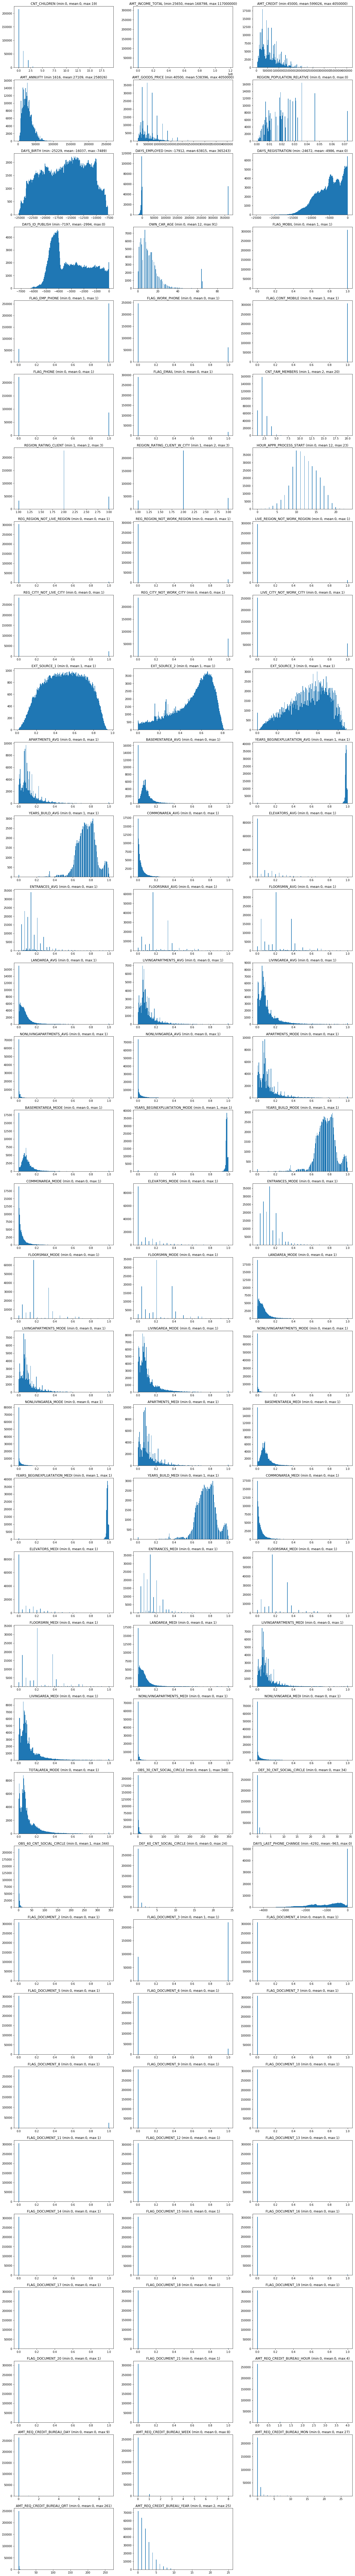

In [9]:
plot_features_hist(application_train, numerical_features)

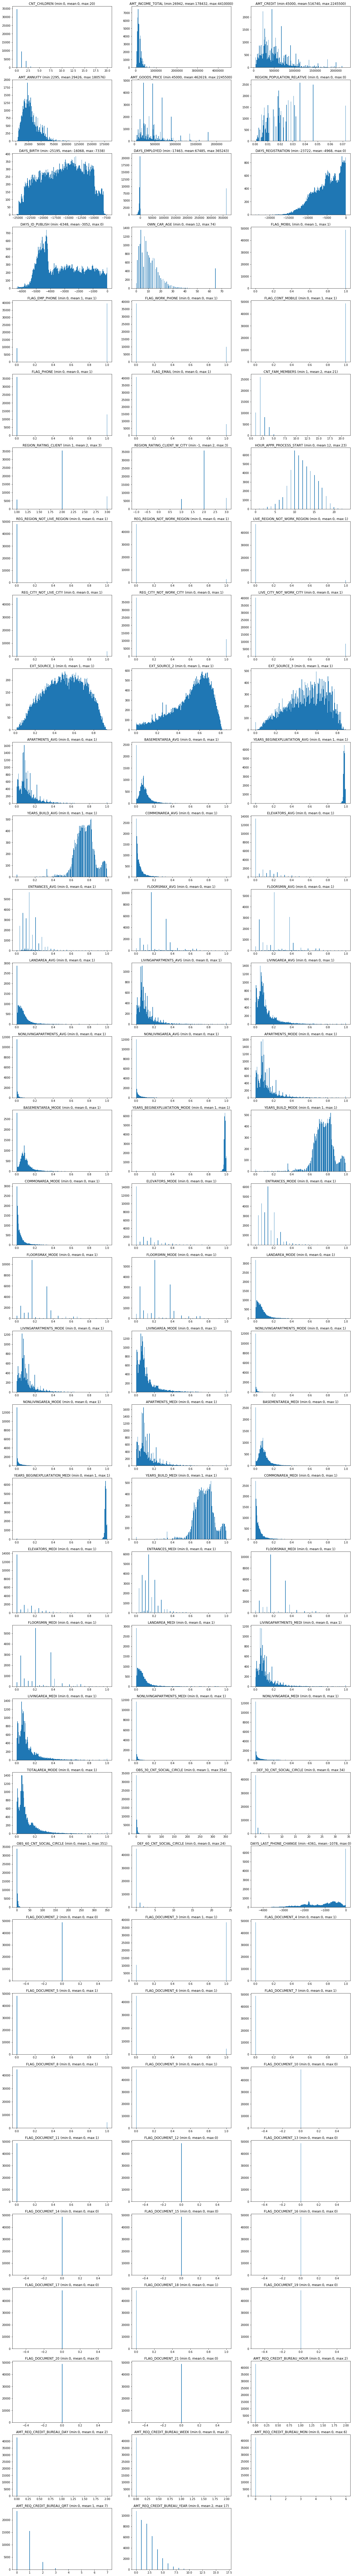

In [10]:
plot_features_hist(application_test, numerical_features)

In [11]:
print('application_test "DAYS_EMPLOYED" anomalies {}, {}%'.format(
    len(application_test[application_test['DAYS_EMPLOYED']==365243]),
    len(application_test[application_test['DAYS_EMPLOYED']==365243]) / len(application_test) * 100))
print('')
print('application_train "DAYS_EMPLOYED" anomalies {}, {}%'.format(
    len(application_train[application_train['DAYS_EMPLOYED']==365243]),
    len(application_train[application_train['DAYS_EMPLOYED']==365243]) / len(application_train) * 100))

application_test "DAYS_EMPLOYED" anomalies 9274, 19.02593139668472%

application_train "DAYS_EMPLOYED" anomalies 55374, 18.00716071945394%


В признаке DAYS_EMPLOYED часто встречается значение 365243. Скорее всего, это какая-то опечатка или характерный баг CRM-ки, не может же сотрудник работать тысячу лет на одном месте. Создадим специальный признак, в котором будет метка о наличии такого явления, а само значение в признаке заменим пропуском.

In [12]:
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243
application_train["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
application_test['DAYS_EMPLOYED_ANOM'] = application_test["DAYS_EMPLOYED"] == 365243
application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

Далее обработаем категориальные признаки

In [13]:
application_train = pd.get_dummies(data=application_train, columns=categorical_features, dummy_na=True)
application_test = pd.get_dummies(data=application_test, columns=categorical_features, dummy_na=True)

In [14]:
print('application_train shape: {} rows {} columns'.format(*application_train.shape))
print('application_test shape: {} rows {} columns'.format(*application_test.shape))

application_train shape: 307511 rows 262 columns
application_test shape: 48744 rows 258 columns


Тренировочный и тестовый наборы теперь имеют разное число признаков. Приведём их к единому виду

In [15]:
application_train, application_test = application_train.align(application_test, join='inner', axis = 1)

print('application_train shape: ', application_train.shape)
print('application_test shape: ', application_test.shape)

application_train shape:  (307511, 258)
application_test shape:  (48744, 258)


Далее разберёмся с пропусками

In [16]:
missing_df = (application_train.isna().sum() / len(application_train)).reset_index()
missing_df.sort_values(ascending=False, by=0)

,index,0
34,COMMONAREA_AVG,0.698723
48,COMMONAREA_MODE,0.698723
62,COMMONAREA_MEDI,0.698723
56,NONLIVINGAPARTMENTS_MODE,0.694330
70,NONLIVINGAPARTMENTS_MEDI,0.694330
...,...,...
1,AMT_INCOME_TOTAL,0.000000
130,NAME_INCOME_TYPE_Unemployed,0.000000
131,NAME_INCOME_TYPE_Working,0.000000
132,NAME_INCOME_TYPE_nan,0.000000


In [17]:
def missing_indicator(df, features=None, inplace=False):
    if not features:
        features = df.columns
    if not inplace:
        df = df.copy()
    for feature in df[features].columns:
        if df[feature].isna().sum() > 0:
            df['missing_'+feature] = df[feature].isna().astype(int)
    return df

In [18]:
application_train = missing_indicator(application_train)
application_test = missing_indicator(application_test)

print('application_train shape: ', application_train.shape)
print('application_test shape: ', application_test.shape)

application_train shape:  (307511, 320)
application_test shape:  (48744, 317)


По всей видимости, в тренировочном и тестовом наборах разный характер пропусков, приведём к единому виду

In [19]:
application_train, application_test = application_train.align(application_test, join='inner', axis = 1)

print('application_train shape: ', application_train.shape)
print('application_test shape: ', application_test.shape)

application_train shape:  (307511, 317)
application_test shape:  (48744, 317)


Далее мы заполним пропуски в вещественных признаках средними значениями. Однако среди вещественных принаков встречаются бинарные признаки, и пропуски в них мы будем заполнять строго нулями

In [20]:
binary_features_train = application_train[numerical_features].nunique()
binary_features_train = binary_features_train[binary_features_train<=2]
binary_features_train = binary_features_train.index

binary_features_test = application_test[numerical_features].nunique()
binary_features_test = binary_features_test[binary_features_test<=2]
binary_features_test = binary_features_test.index

min(binary_features_train == binary_features_test)

True

In [21]:
binary_features_train

Index(['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],
      dtype='object')

In [22]:
application_train[binary_features_train] = application_train[binary_features_train].fillna(0)
application_test[binary_features_test] = application_test[binary_features_test].fillna(0)

In [23]:
mean_imputer = Imputer(missing_values='NaN', strategy='mean')
application_train[numerical_features] = mean_imputer.fit_transform(application_train[numerical_features])
application_test[numerical_features] = mean_imputer.transform(application_test[numerical_features])

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Теперь проверим, нет ли у нас признаков скореллированных с целевой переменной

In [24]:
application_train.corrwith(y).sort_values(ascending=False)

DAYS_BIRTH                        0.078239
DAYS_EMPLOYED                     0.070075
REGION_RATING_CLIENT_W_CITY       0.060893
REGION_RATING_CLIENT              0.058899
NAME_INCOME_TYPE_Working          0.057481
                                    ...   
NAME_EDUCATION_TYPE_nan                NaN
NAME_FAMILY_STATUS_nan                 NaN
NAME_HOUSING_TYPE_nan                  NaN
WEEKDAY_APPR_PROCESS_START_nan         NaN
ORGANIZATION_TYPE_nan                  NaN
Length: 317, dtype: float64

In [25]:
application_train.corrwith(y).sort_values()

EXT_SOURCE_2                           -0.160303
EXT_SOURCE_3                           -0.157397
EXT_SOURCE_1                           -0.099152
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
                                          ...   
NAME_EDUCATION_TYPE_nan                      NaN
NAME_FAMILY_STATUS_nan                       NaN
NAME_HOUSING_TYPE_nan                        NaN
WEEKDAY_APPR_PROCESS_START_nan               NaN
ORGANIZATION_TYPE_nan                        NaN
Length: 317, dtype: float64

### Model selection

In [26]:
!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
!git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 14686, done.
remote: Total 14686 (delta 0), reused 0 (delta 0), pack-reused 14686
Receiving objects: 100% (14686/14686), 10.27 MiB | 2.53 MiB/s, done.
Resolving deltas: 100% (10567/10567), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/kaggle/working/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 2.31 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'


In [27]:
!apt-get install -y -qq libboost-all-dev

debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package autotools-dev.
(Reading database ... 60687 files and directories currently installed.)
Preparing to unpack .../000-autotools-dev_20161112.1_all.deb ...
Unpacking autotools-dev (20161112.1) ...
Preparing to unpack .../001-libicu57_57.1-6+deb9u3_amd64.deb ...
Unpacking libicu57:amd64 (57.1-6+deb9u3) over (57.1-6+deb9u2) ...
Selecting previously unselected package icu-devtools.
Preparing to unpack .../002-icu-devtools_57.1-6+deb9u3_amd64.deb ...
Unpacking icu-devtools (57.1-6+deb9u3) ...
Selecting previously unselected package libboost1.62-dev:amd64.
Preparing to unpack .../003-libboost1.62-dev_1.62.0+dfsg-4_amd64.deb ...
Unpacking libboost1.62-dev:amd64 (1.62.0+dfsg-4) ...
Selecting previously unselected package libboost-dev:amd64.
Preparing to unpack .../004-libboost-dev_1.62.0.1_amd64.deb ...
Unpacking libboost-dev:amd64 (1.62.0.1) ...
Selecting previously unselected packag

In [28]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

-- The C compiler identification is GNU 6.3.0
-- The CXX compiler identification is GNU 6.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Try OpenMP C flag = [-fopenmp]
-- Performing Test OpenMP_FLAG_DETECTED
-- Performing Test OpenMP_FLAG_DETECTED - Success
-- Try OpenMP CXX flag = [-fopenmp]
-- Performing Test OpenMP_FLAG_DETECTED
-- Performing Test OpenMP_FLAG_DETECTED - Success
-- Found OpenMP: -fopenmp  
-- Looking for CL_VERSION_2_0
-- Looking for CL_VERSION_2_0 - not found
-- Looking for CL_VERSION_1_2
-- Looking for CL_VERSION_

rm: cannot remove 'build': No such file or directory


In [29]:
!cd LightGBM/python-package/;python3 setup.py install --precompile

running install
running build
running build_py
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'build'
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
copying lightgbm/VERSION.t

In [30]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

In [31]:
!nvidia-smi

Fri Nov  1 13:11:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [32]:
param = {
        'num_leaves': 10,
        'max_bin': 127,
        'min_data_in_leaf': 11,
        'learning_rate': 0.02,
        'min_sum_hessian_in_leaf': 0.00245,
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': 0.05,
        'lambda_l1': 4.972,
        'lambda_l2': 2.276,
        'min_gain_to_split': 0.65,
        'max_depth': 14,
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

In [33]:
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

In [34]:
%%time
nfold = 2

target = 'target'
predictors = application_train.columns.values.tolist()

skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(application_train))
predictions = np.zeros(len(application_test))

i = 1
for train_index, valid_index in skf.split(application_train, y.values):
    print("\nfold {}".format(i))
    xg_train = lgb.Dataset(application_train.iloc[train_index][predictors].values,
                           label=y.iloc[train_index].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(application_train.iloc[valid_index][predictors].values,
                           label=y.iloc[valid_index].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )   

    
    clf = lgb.train(param, xg_train, 5000, valid_sets = [xg_valid], verbose_eval=50, early_stopping_rounds = 50)
    oof[valid_index] = clf.predict(application_train.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    
    predictions += clf.predict(application_test[predictors], num_iteration=clf.best_iteration) / nfold
    i = i + 1

print("\n\nCV AUC: {:<0.2f}".format(metrics.roc_auc_score(y.values, oof)))


fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.686095
[100]	valid_0's auc: 0.710475
[150]	valid_0's auc: 0.717486
[200]	valid_0's auc: 0.721872
[250]	valid_0's auc: 0.728016
[300]	valid_0's auc: 0.732625
[350]	valid_0's auc: 0.735047
[400]	valid_0's auc: 0.737473
[450]	valid_0's auc: 0.740216
[500]	valid_0's auc: 0.741263
[550]	valid_0's auc: 0.743745
[600]	valid_0's auc: 0.745227
[650]	valid_0's auc: 0.746098
[700]	valid_0's auc: 0.747247
[750]	valid_0's auc: 0.748601
[800]	valid_0's auc: 0.749499
[850]	valid_0's auc: 0.750142
[900]	valid_0's auc: 0.750661
[950]	valid_0's auc: 0.751136
[1000]	valid_0's auc: 0.75142
[1050]	valid_0's auc: 0.751888
[1100]	valid_0's auc: 0.752225
[1150]	valid_0's auc: 0.752531
[1200]	valid_0's auc: 0.752931
[1250]	valid_0's auc: 0.753155
[1300]	valid_0's auc: 0.753344
[1350]	valid_0's auc: 0.753656
[1400]	valid_0's auc: 0.753845
[1450]	valid_0's auc: 0.75401
[1500]	valid_0's auc: 0.754187
[1550]	valid_0's auc: 0

Модель показывает ROC_AUC 0.75 на тренировочных данных

In [35]:
sample_submission = pd.read_csv(path+'sample_submission.csv')
sample_submission

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5
...,...,...
48739,456221,0.5
48740,456222,0.5
48741,456223,0.5
48742,456224,0.5


In [36]:
my_submission = pd.DataFrame({'SK_ID_CURR': application_test.index, 'TARGET': predictions})
my_submission

,SK_ID_CURR,TARGET
0,100001,0.358244
1,100005,0.589612
2,100013,0.230145
3,100028,0.238112
4,100038,0.687915
...,...,...
48739,456221,0.294781
48740,456222,0.510155
48741,456223,0.325138
48742,456224,0.417280


In [37]:
my_submission.to_csv('submission.csv', index=False)

In [38]:
my_submission

,SK_ID_CURR,TARGET
0,100001,0.358244
1,100005,0.589612
2,100013,0.230145
3,100028,0.238112
4,100038,0.687915
...,...,...
48739,456221,0.294781
48740,456222,0.510155
48741,456223,0.325138
48742,456224,0.417280


In [39]:
from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv